In [36]:
import numpy as np
import joblib
import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch

import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [37]:
def db_score(model, X):
    model.fit(X)
    clusters = model['cluster'].labels_
    try:
        score = -davies_bouldin_score(X, clusters)
    except:
        score = -np.inf

    return score

def ch_score(model, X):
    model.fit(X)
    clusters = model['cluster'].labels_
    score = calinski_harabasz_score(X, clusters)


    return score

def clustereing_score(model, X):
    dict_score = {}

    model.fit(X)
    clusters = model['cluster'].labels_

    try:
        dict_score['davies_bouldin'] = -davies_bouldin_score(X, clusters)
    except:
        dict_score['davies_bouldin'] = -np.inf
    try:
        dict_score['calinski_harabasz'] = calinski_harabasz_score(X, clusters)
    except:
        dict_score['calinski_harabasz'] = -np.inf
    return dict_score

def return_save_result(gs, name='model', list_save=[], path='clustering'):
    db_best_score = gs.cv_results_['mean_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
    ch_best_score = gs.cv_results_['mean_test_calinski_harabasz'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
    db_rank = gs.cv_results_['rank_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]

    print('Davies Bouldin Score: {:.3f} (Closer to 0 is better)'.format(db_best_score))
    print('calinski_harabasz Score: {:.3f} (Higher is better)'.format(ch_best_score))
    print('Best model by Calinski-Harabasz metric is ranked: {} using the Davies-Bouldin metric'.format(db_rank))

    clustering_score.append([name, db_best_score, ch_best_score, computation_time])
    joblib.dump(gs.best_estimator_, 'models/{}/{}.joblib'.format(path, name));

    return clustering_score


# We will try multiple clustering algorithms:
* Baseline: Cluster according to the whiskey type
* K-Means
* Affinity Propagation
* Mean Shift
* Spectral clustering
* Agglomerative clustering
* DBSCAN
* OPTICS

## Doing a full grid search for all this models with the full dataset will take too much time. So we will do the following:
### 1. Do model fitting using the whole dataset with the default parameters

This will allow to have an idea of the computational efficiency of the models, and if necessary remove the ones that are too computationally demanding to do a grid-search.

### 2. Do a grid search using only part of the model

This will allow to fine-tune the models, and select the best candidate for the grid-search on the full dataset, and thus reducing computation time.

### 3. Do a grid search of the best model with the whole dataset

In [38]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()
pca = PCA(n_components=2)

# 0. Load the cleaned dataset

In [39]:
df = joblib.load('dataset/cleaned_dataset.joblib')

### We remove the username columns, because binary features like this ones are very difficult to handle for most clustering techniques. We will do the same later (after the baseline) with the type columns

In [40]:
user_col = [col for col in df.columns if 'Username_' in col]
df.drop(user_col, inplace=True, axis=1)

# 1. Fitting using default parameters

In [41]:
def clustereing_score_single_model(model, X, fit_name='model', gaussian=False):
    dict_score = {}

    model.fit(X)
    joblib.dump(model, 'models/clustering_default_parameters/{}.joblib'.format(fit_name))
    if gaussian:
        pass
    else:
        clusters = model.labels_

    try:
        dict_score['davies_bouldin'] = -davies_bouldin_score(X, clusters)
    except:
        dict_score['davies_bouldin'] = -np.inf
    try:
        dict_score['calinski_harabasz'] = calinski_harabasz_score(X, clusters)
    except:
        dict_score['calinski_harabasz'] = -np.inf
    return dict_score


models = {'KMeans': MiniBatchKMeans(batch_size=3072),
          'Affinity_Propagation': AffinityPropagation(),
          'Mean_Shift': MeanShift(n_jobs=-1, bin_seeding=True, min_bin_freq = 10), # these parameters speed up the computation time by A LOT (from 30mins to 10s)
          'Spectral_Clustering': SpectralClustering(n_jobs=-1),
          'Agglomerative_Clustering': AgglomerativeClustering(),
          'DBSCAN': DBSCAN(n_jobs=-1),
          }


clustering_score_default = []

df_sample = df#.sample(100)

df_sample.reset_index(inplace=True, drop=True)
X = df_sample.select_dtypes(include=np.number)

cols = ['Type_' in col for col in df.columns]
start_time = time.time()
labels = df_sample.iloc[:, cols].idxmax(axis=1).str.replace('Type_', '').factorize()[0]

db = -davies_bouldin_score(X, labels)
ch = calinski_harabasz_score(X, labels)

computation_time = time.time() - start_time

clustering_score_default.append(['Baseline', db, ch, computation_time])

# removing the type columns, as discussed in the Markdown above
type_col = [col for col in df.columns if 'Type_' in col]
df_tmp = df.drop(type_col, inplace=False, axis=1)
df_sample = df_tmp#.sample(100)
df_sample.reset_index(inplace=True, drop=True)
X = df_sample.select_dtypes(include=np.number)

for key in models.keys():
    start_time = time.time()

    result = clustereing_score_single_model(models[key], X, fit_name=key)

    computation_time = time.time() - start_time

    clustering_score_default.append([key, result['davies_bouldin'], result['calinski_harabasz'], computation_time])
    print(key + ' is done! Time to fit was: {}s.'.format(np.round(computation_time,2)))


KMeans is done! Time to fit was: 0.46s.
Affinity_Propagation is done! Time to fit was: 646.32s.
Mean_Shift is done! Time to fit was: 8.44s.
Spectral_Clustering is done! Time to fit was: 14.58s.
Agglomerative_Clustering is done! Time to fit was: 11.8s.
DBSCAN is done! Time to fit was: 1.42s.


In [42]:
df_score_default = pd.DataFrame(clustering_score_default, columns=['Model Name', 'Davies Bouldin', 'Calinski Harabasz', 'Computation Time'])
joblib.dump(df_score_default, 'scores/default.joblib');

### Affinity Propagation takes too much time, and doesn't seem to perform the best so we will ignore them for the grid search.

### DBSCAN seems to have issue with the clustering (score of 0 means that there was only one cluster). Lets see if using PCA before the clustering will help.

# 1. Fitting using grid-search on partial dataset

In [43]:
clustering_score = []

df_sample = df.sample(1000)
df_sample.reset_index(inplace=True, drop=True)
X = df_sample.select_dtypes(include=np.number)

## 1.1 Baseline

In [44]:
cols = ['Type_' in col for col in df.columns]

labels = df_sample.iloc[:, cols].idxmax(axis=1).str.replace('Type_', '').factorize()[0]
start_time = time.time()
db = -davies_bouldin_score(X, labels)
ch = calinski_harabasz_score(X, labels)
computation_time = time.time() - start_time

print('Davies Bouldin Score: {:.3f} (Closer to 0 is better)'.format(db))
print('calinski_harabasz Score: {:.3f} (Higher is better)'.format(ch))

clustering_score.append(['Baseline', db, ch, computation_time])

Davies Bouldin Score: -7.944 (Closer to 0 is better)
calinski_harabasz Score: 5.653 (Higher is better)


### Same as before, we remove the Type_ columns

In [45]:
type_col = [col for col in df.columns if 'Type_' in col]
df_sample.drop(type_col, inplace=True, axis=1)
X = df_sample.select_dtypes(include=np.number)

## 1.2 K-Means

In [46]:
kmean = MiniBatchKMeans()

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', pca), ("cluster", kmean)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction': ['passthrough', PCA(10), PCA(20), PCA(30), PCA(40),PCA(50), PCA(100)],
              'cluster__n_clusters': np.arange(50, 250, 50),
              'cluster__batch_size': [256*12]
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

clustering_score = return_save_result(gs, 'MiniBatchKMeans', clustering_score)

Davies Bouldin Score: -2.162 (Closer to 0 is better)
calinski_harabasz Score: 2151.551 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 11 using the Davies-Bouldin metric


['computation_time/clustering/MiniBatchKMeans.joblib']

## 1.3 Mean Shift

In [47]:
meanshift = MeanShift(n_jobs=-1, bin_seeding=True, min_bin_freq = 10)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', pca), ("cluster", meanshift)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction': ['passthrough', PCA(10), PCA(20), PCA(30), PCA(40),PCA(50), PCA(100)],
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

clustering_score = return_save_result(gs, 'MeanShift', clustering_score)

Davies Bouldin Score: -43.220 (Closer to 0 is better)
calinski_harabasz Score: 0.175 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 1 using the Davies-Bouldin metric


['computation_time/clustering/MeanShift.joblib']

## 1.4 Spectral Clustering

In [48]:
spectral = SpectralClustering(n_jobs=-1)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', pca), ("cluster", spectral)])

param_grid = {'scaling': ['passthrough'],#, standard_scaler, robust_scaler], #Using the scaler lead to an error during fitting
              'dim_reduction': ['passthrough', PCA(10), PCA(20), PCA(30), PCA(40),PCA(50), PCA(100)],
              'cluster__n_clusters': np.arange(50,250, 50),
              'cluster__affinity': ['nearest_neighbors', 'rbf']
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

clustering_score = return_save_result(gs, 'SpectralClustering', clustering_score)

Davies Bouldin Score: -1.824 (Closer to 0 is better)
calinski_harabasz Score: 1612.589 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 7 using the Davies-Bouldin metric


['computation_time/clustering/SpectralClustering.joblib']

## 1.5 Agglomerative Clustering

In [49]:
agglomerative = AgglomerativeClustering(compute_distances=True, distance_threshold=None)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', pca), ("cluster", agglomerative)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction': ['passthrough', PCA(10), PCA(20), PCA(30), PCA(40),PCA(50), PCA(100)],
              'cluster__n_clusters': np.arange(50,250, 50)
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

clustering_score = return_save_result(gs, 'AgglomerativeClustering', clustering_score)

Davies Bouldin Score: -1.708 (Closer to 0 is better)
calinski_harabasz Score: 2210.777 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 7 using the Davies-Bouldin metric


['computation_time/clustering/AgglomerativeClustering.joblib']

## 1.6 DBSCAN

In [50]:
dbscan = DBSCAN(n_jobs=-1)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', pca), ("cluster", dbscan)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction': ['passthrough', PCA(10), PCA(20), PCA(30), PCA(40),PCA(50)],
              'cluster__eps': np.arange(0.1,1.0, 0.2),
              'cluster__min_samples': np.arange(10,50,20),
              'cluster__metric': ['cosine', 'l2']
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

clustering_score = return_save_result(gs, 'DBSCAN', clustering_score)

Davies Bouldin Score: -0.791 (Closer to 0 is better)
calinski_harabasz Score: 623.818 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 1 using the Davies-Bouldin metric


['computation_time/clustering/DBSCAN.joblib']

## Save the results in a dataframe

In [51]:
df_score_partial = pd.DataFrame(clustering_score, columns=['Model Name', 'Davies Bouldin', 'Calinski Harabasz', 'Computation Time'])
joblib.dump(df_score_partial, 'scores/grid.joblib'.format(key))

['scores/grid.joblib']

# 2. Fitting the two best models with the full dataset (MeanShift and DBSCAN)
## We will reduce the size of the grid search to reduce computation time

## Lets look at the best parameters of the models fitted on the partial dataset

In [52]:
meanshift_model = joblib.load('models/clustering/MeanShift.joblib')
DBSCAN_model = joblib.load('models/clustering/DBSCAN.joblib')


In [53]:
meanshift_model

Pipeline(steps=[('scaling', RobustScaler()),
                ('dim_reduction', PCA(n_components=10)),
                ('cluster',
                 MeanShift(bin_seeding=True, min_bin_freq=10, n_jobs=-1))])

In [54]:
DBSCAN_model

Pipeline(steps=[('scaling', 'passthrough'),
                ('dim_reduction', PCA(n_components=50)),
                ('cluster',
                 DBSCAN(eps=0.1, metric='cosine', min_samples=30, n_jobs=-1))])

In [55]:
# df.reset_index(inplace=True, drop=True)
type_col = [col for col in df.columns if 'Type_' in col]
df.drop(type_col, inplace=True, axis=1)
X = df.select_dtypes(include=np.number)

clustering_score_all = []

## 2.1 Mean Shift

In [56]:
meanshift = MeanShift(n_jobs=-1, bin_seeding=True, min_bin_freq = 10)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', pca), ("cluster", meanshift)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction': ['passthrough', PCA(50), PCA(70), PCA(100)],
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

db_best_score = gs.cv_results_['mean_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
ch_best_score = gs.cv_results_['mean_test_calinski_harabasz'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
db_rank = gs.cv_results_['rank_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]

print('Davies Bouldin Score: {:.3f} (Closer to 0 is better)'.format(db_best_score))
print('calinski_harabasz Score: {:.3f} (Higher is better)'.format(ch_best_score))
print('Best model by Calinski-Harabasz metric is ranked: {} using the Davies-Bouldin metric'.format(db_rank))


joblib.dump(gs.best_estimator_, 'models/{}/{}.joblib'.format('clustering_all_dataset', 'MeanShift'));
clustering_score_all.append(['Mean Shift' ,db_best_score, ch_best_score, computation_time])


Davies Bouldin Score: -0.500 (Closer to 0 is better)
calinski_harabasz Score: 7312.018 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 4 using the Davies-Bouldin metric


## 2.2 DBSCAN

In [57]:
dbscan = DBSCAN(n_jobs=-1)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', pca), ("cluster", dbscan)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction': ['passthrough', PCA(50), PCA(70), PCA(100)],
              'cluster__eps': np.arange(0.01,0.6, 0.01),
              'cluster__min_samples': np.arange(10,50,20),
              'cluster__metric': ['cosine']
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz', n_jobs=-1)

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

db_best_score = gs.cv_results_['mean_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
ch_best_score = gs.cv_results_['mean_test_calinski_harabasz'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
db_rank = gs.cv_results_['rank_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]

print('Davies Bouldin Score: {:.3f} (Closer to 0 is better)'.format(db_best_score))
print('calinski_harabasz Score: {:.3f} (Higher is better)'.format(ch_best_score))
print('Best model by Calinski-Harabasz metric is ranked: {} using the Davies-Bouldin metric'.format(db_rank))


clustering_score_all.append(['DBSCAN' ,db_best_score, ch_best_score, computation_time])
joblib.dump(gs.best_estimator_, 'models/{}/{}.joblib'.format('clustering_all_dataset', 'DBSCAN'));

Davies Bouldin Score: -0.685 (Closer to 0 is better)
calinski_harabasz Score: 12474.255 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 2 using the Davies-Bouldin metric


In [58]:
df_full = pd.DataFrame(clustering_score_all, columns=['Model Name', 'Davies Bouldin', 'Calinski Harabasz', 'Computation Time'])
joblib.dump(df_full, 'scores/full.joblib')

['scores/full.joblib']

# 3. Load all the models and scores for further analysis

In [59]:
import glob

df_dict = {}

for model_type in glob.glob('scores/*'):
    df_dict[model_type.split('\\')[1].split('.')[0]] = joblib.load(model_type)

Text(0, 0.5, 'Grid Search on full dataset')

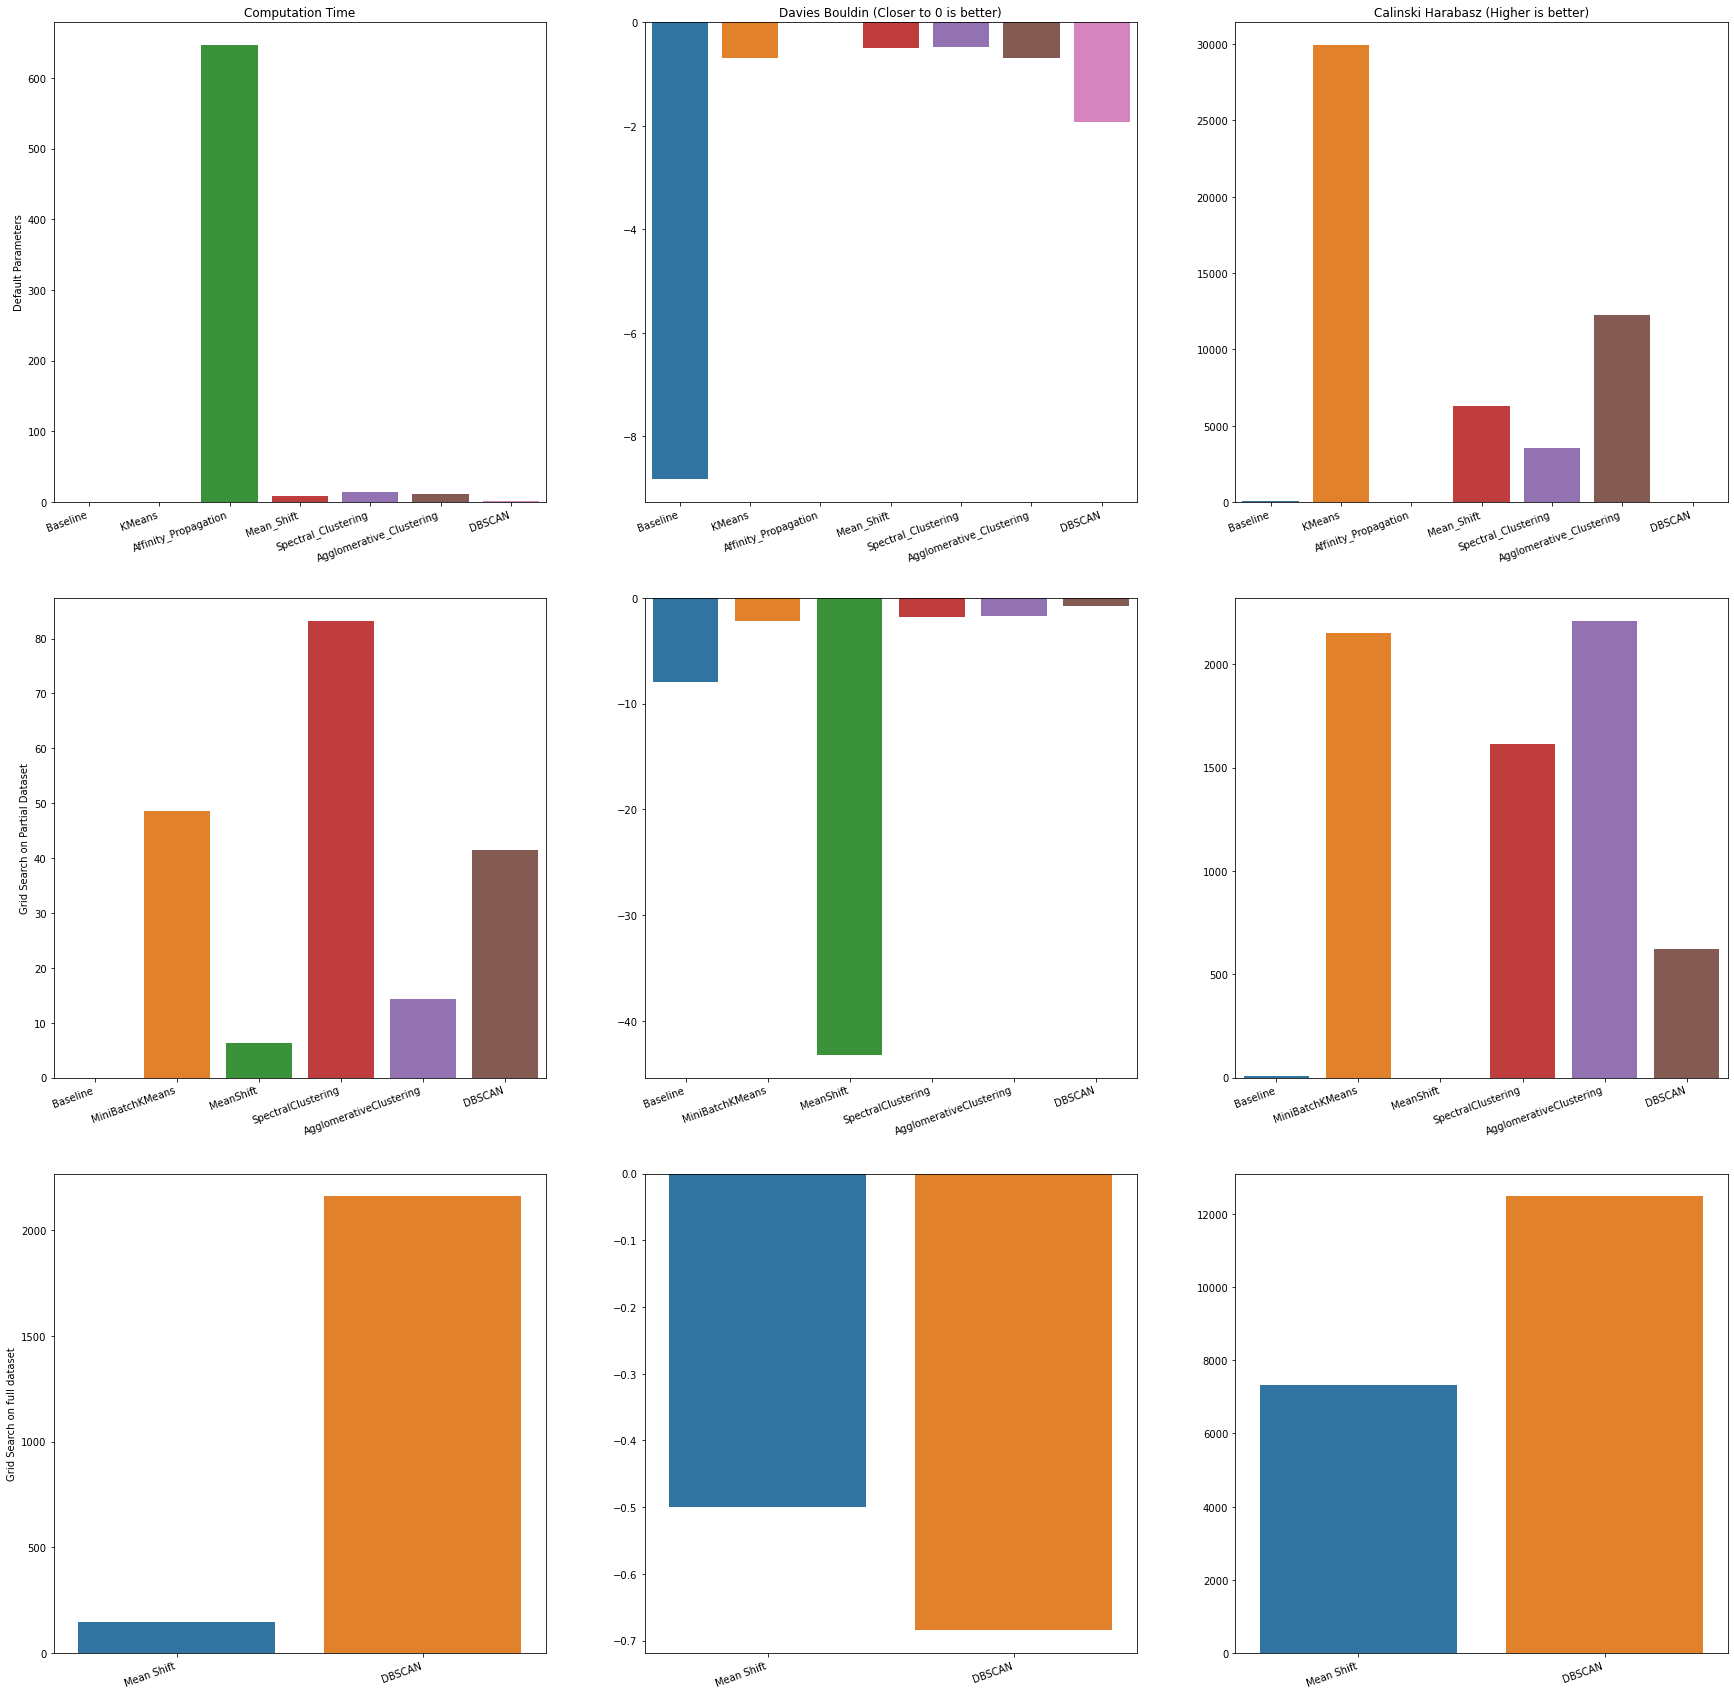

In [60]:
fig, axes = plt.subplots(3,3, figsize=(30,30))

for i, key in enumerate(['default', 'grid', 'full']):
    sns.barplot(data=df_dict[key], x='Model Name', y='Computation Time', ax=axes[i,0])
    sns.barplot(data=df_dict[key], x='Model Name', y='Davies Bouldin', ax=axes[i,1])
    sns.barplot(data=df_dict[key], x='Model Name', y='Calinski Harabasz', ax=axes[i,2])
    for j in range(0,3):
        axes[i,j].set_ylabel('')
        axes[i,j].set_xlabel('')
        plt.setp(axes[i,j].get_xticklabels(), rotation=20, ha='right')

axes[0,0].set_title('Computation Time')
axes[0,1].set_title('Davies Bouldin (Closer to 0 is better)')
axes[0,2].set_title('Calinski Harabasz (Higher is better)')
axes[0,0].set_ylabel('Default Parameters')
axes[1,0].set_ylabel('Grid Search on Partial Dataset')
axes[2,0].set_ylabel('Grid Search on full dataset')


## Mean Shift seems to be performing better on the full dataset with grid-search in all the metrics (computation time and clustering performance)

In [61]:
best_model = joblib.load('models/clustering_all_dataset/MeanShift.joblib')

In [62]:
# df_sample = df#.sample(1000)
# df_sample.reset_index(inplace=True, drop=True)
# X = df_sample.select_dtypes(include=np.number)

compressed = PCA(2).fit_transform(X)

In [63]:
#df.dropna(inplace=True)

In [65]:
df_compressed = pd.DataFrame({'Whiskey Name': df['Whiskey Name'], 'PCA_1': compressed[:,0], 'PCA_2': compressed[:,1], 'labels':best_model['cluster'].labels_})

In [66]:
df_sample = df_compressed#.sample(300)

<AxesSubplot:xlabel='PCA_1', ylabel='PCA_2'>

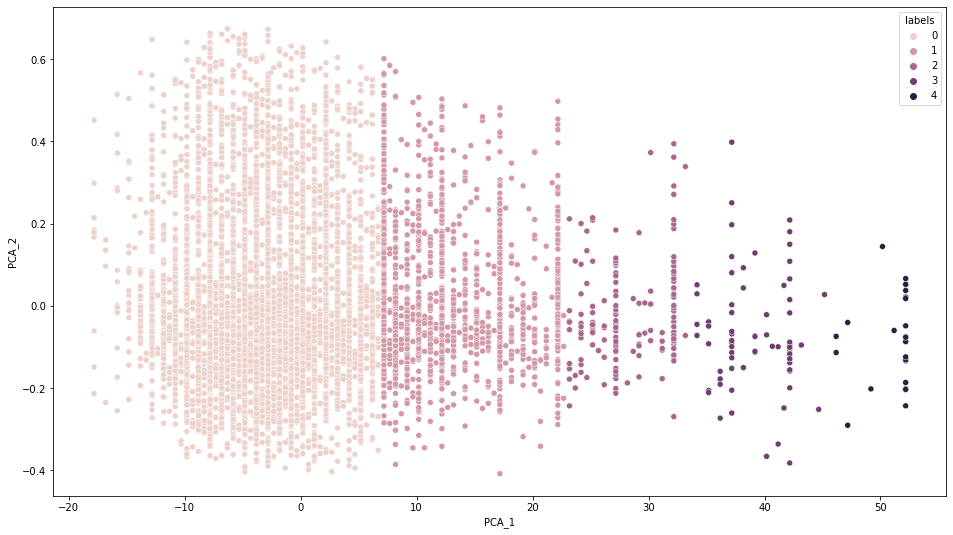

In [67]:
from seaborn import color_palette

plt.figure(figsize=(16,9))
sns.scatterplot(data=df_sample, x='PCA_1', y='PCA_2', hue='labels')#, palette=color_palette("tab10")[:len(df_sample['labels'].unique())])

# Extra. Alternatives

## Extra.1 Using a pre-trained bert model instead of tf-idf

### Maybe one of the issue of the clustering is that TF-IDF is too "naive" for clustering the reviews. One of the issue we have, that could also be solved by looking at the ngram parameters of the TF-IDF, is the fact that we only have the information about the words, without their context. So, "not good" and "good" will probably be mixxed up for example.

### Bert is an encoder that is able to embed words in a contextual way, so maybe it could help.

### Here we are using a pre-trained model from tensorflow-hub

In [68]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/wiki_books/sst2/2')


In [69]:
import sys

result = []
start_time = time.time()

for i, review in enumerate(df['Review']):
    bert_inputs = preprocess([review])
    bert_outputs = bert(bert_inputs, training=False)
    pooled_output = bert_outputs['pooled_output']
    sequence_output = bert_outputs['sequence_output']
    result.append([pooled_output, sequence_output])
computation_time = time.time() - start_time

In [70]:
todf = []
for i in result:
    todf.append(i[0].numpy()[0])

In [71]:
bert_df = pd.DataFrame(todf)

In [72]:
meanshift = MeanShift(n_jobs=-1,bandwidth=30, bin_seeding=True, min_bin_freq = 10)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', pca), ("cluster", meanshift)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction': ['passthrough', PCA(50), PCA(70), PCA(100)],
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(bert_df.values);
computation_time = time.time() - start_time

db_best_score = gs.cv_results_['mean_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
ch_best_score = gs.cv_results_['mean_test_calinski_harabasz'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
db_rank = gs.cv_results_['rank_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]

print('Davies Bouldin Score: {:.3f} (Closer to 0 is better)'.format(db_best_score))
print('calinski_harabasz Score: {:.3f} (Higher is better)'.format(ch_best_score))
print('Best model by Calinski-Harabasz metric is ranked: {} using the Davies-Bouldin metric'.format(db_rank))


Davies Bouldin Score: -1.264 (Closer to 0 is better)
calinski_harabasz Score: 202.651 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 1 using the Davies-Bouldin metric


<AxesSubplot:xlabel='PCA_1', ylabel='PCA_2'>

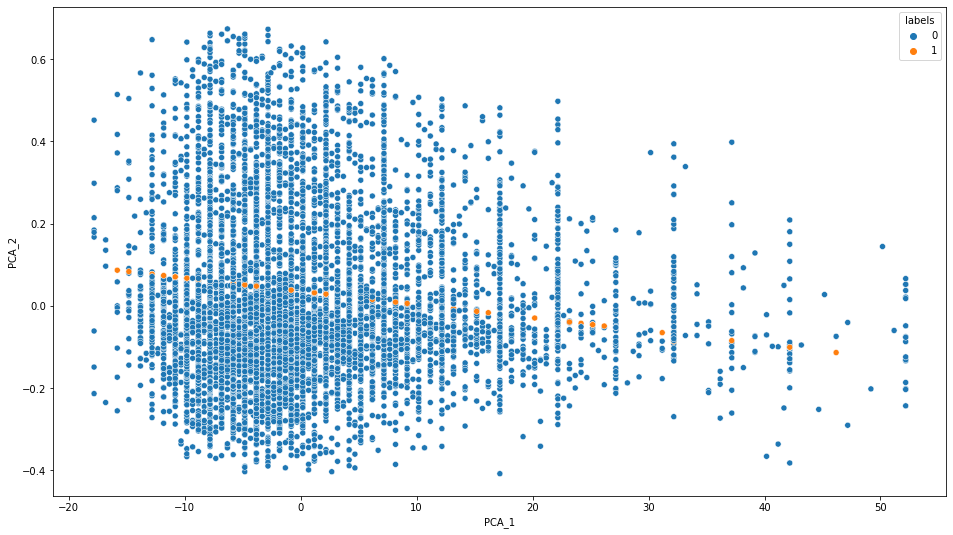

In [73]:
df_compressed = pd.DataFrame({'Whiskey Name': df['Whiskey Name'], 'PCA_1': compressed[:,0], 'PCA_2': compressed[:,1], 'labels':gs.best_estimator_['cluster'].labels_})

plt.figure(figsize=(16,9))
sns.scatterplot(data=df_compressed, x='PCA_1', y='PCA_2', hue='labels')#, palette=color_palette("tab10")[:len(df_sample['labels'].unique())])

### The Pipeline using BERT instead of TF-IDF doesn't seems to perform better, and we lose interpretability, so we will stick to TF-IDF

## Extra.2 Using TruncatedSVD instead of PCA

### Another issue is the scarcity of the dataset. Most of the columns are basically filled with 0, which makes clustering difficult. PCA is not optimal for sparse dataset.

### According to the documentation of sklearn, TruncatedSVD works well on TF-IDF matrices, so it could be a better candidate than PCA.

In [74]:
df_sample = df#.sample(1000)
df_sample.reset_index(inplace=True, drop=True)
X = df_sample.select_dtypes(include=np.number)

In [75]:
from sklearn.decomposition import TruncatedSVD

TSVD = TruncatedSVD(n_components=20)
meanshift = MeanShift(n_jobs=-1, bin_seeding=True, min_bin_freq = 10)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', TruncatedSVD), ("cluster", meanshift)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction': [TruncatedSVD(n_components=20), TruncatedSVD(n_components=50), TruncatedSVD(n_components=70), TruncatedSVD(n_components=100)],
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

db_best_score = gs.cv_results_['mean_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
ch_best_score = gs.cv_results_['mean_test_calinski_harabasz'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
db_rank = gs.cv_results_['rank_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]

print('Davies Bouldin Score: {:.3f} (Closer to 0 is better)'.format(db_best_score))
print('calinski_harabasz Score: {:.3f} (Higher is better)'.format(ch_best_score))
print('Best model by Calinski-Harabasz metric is ranked: {} using the Davies-Bouldin metric'.format(db_rank))


Davies Bouldin Score: -0.500 (Closer to 0 is better)
calinski_harabasz Score: 7312.018 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 3 using the Davies-Bouldin metric


In [76]:
gs.best_estimator_

Pipeline(steps=[('scaling', 'passthrough'),
                ('dim_reduction', TruncatedSVD(n_components=20)),
                ('cluster',
                 MeanShift(bin_seeding=True, min_bin_freq=10, n_jobs=-1))])

<AxesSubplot:xlabel='SVD_1', ylabel='SVD_2'>

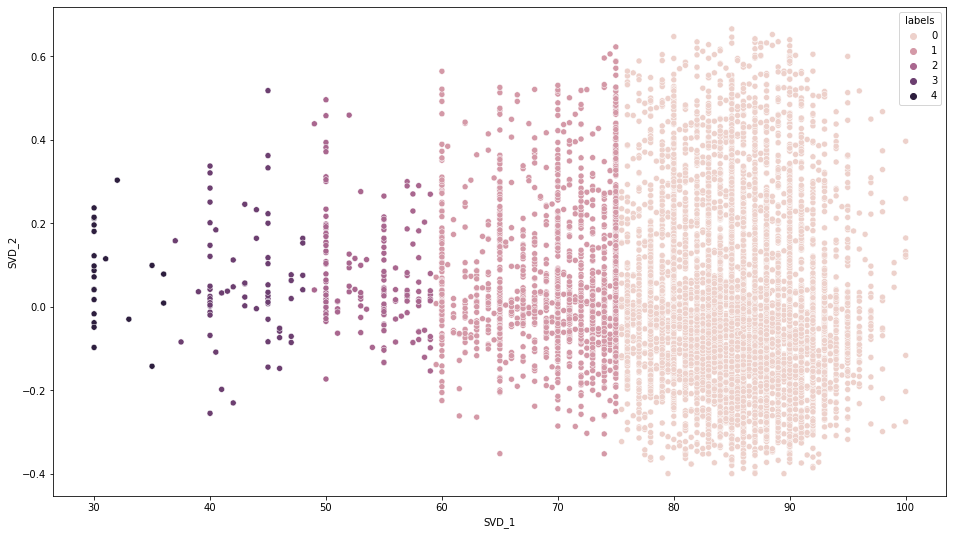

In [77]:
compressed_SVD = TruncatedSVD(2).fit_transform(X)

df_compressed = pd.DataFrame({'Whiskey Name': df['Whiskey Name'], 'SVD_1': compressed_SVD[:,0], 'SVD_2': compressed_SVD[:,1], 'labels':gs.best_estimator_['cluster'].labels_})

plt.figure(figsize=(16,9))
sns.scatterplot(data=df_compressed, x='SVD_1', y='SVD_2', hue='labels')#, palette=color_palette("tab10")[:len(df_sample['labels'].unique())])

## Extra.3 Using UMAP instead of PCA

### This one is a non-linear decomposition, so it may be possible that it works better than the linear decomposition tested previously

In [78]:
import umap
import joblib
import numpy as np
import matplotlib.pyplot as plt

import umap.plot


In [79]:
df = joblib.load('dataset/cleaned_dataset.joblib')
user_col = [col for col in df.columns if 'Username_' in col]
df.drop(user_col, inplace=True, axis=1)

df_sample = df
df_sample.reset_index(inplace=True, drop=True)
X = df_sample.select_dtypes(include=np.number)

In [80]:
trans = umap.UMAP(n_neighbors=10, random_state=42).fit(X)

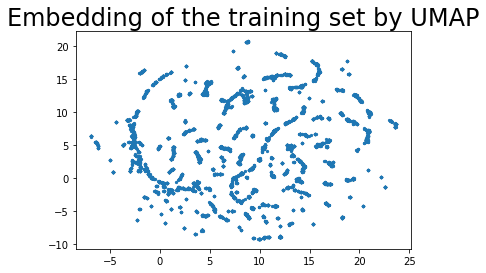

In [81]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24);

## This seems promising, since now the data is bunched up in small groups

In [83]:
umap_model = umap.UMAP(n_neighbors=5)
meanshift = MeanShift(n_jobs=-1, bin_seeding=True, min_bin_freq = 10)

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', umap_model), ("cluster", meanshift)])

param_grid = {'scaling': ['passthrough', standard_scaler, robust_scaler],
              'dim_reduction__n_neighbors': [25, 50, 100, 250],
              'dim_reduction__metric': ['cosine', 'euclidean']
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time

db_best_score = gs.cv_results_['mean_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
ch_best_score = gs.cv_results_['mean_test_calinski_harabasz'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]
db_rank = gs.cv_results_['rank_test_davies_bouldin'][gs.cv_results_['rank_test_calinski_harabasz'] == 1][0]

print('Davies Bouldin Score: {:.3f} (Closer to 0 is better)'.format(db_best_score))
print('calinski_harabasz Score: {:.3f} (Higher is better)'.format(ch_best_score))
print('Best model by Calinski-Harabasz metric is ranked: {} using the Davies-Bouldin metric'.format(db_rank))


Davies Bouldin Score: -0.821 (Closer to 0 is better)
calinski_harabasz Score: 7553.525 (Higher is better)
Best model by Calinski-Harabasz metric is ranked: 1 using the Davies-Bouldin metric


In [84]:
gs.best_estimator_

Pipeline(steps=[('scaling', 'passthrough'),
                ('dim_reduction',
                 UMAP(n_neighbors=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('cluster',
                 MeanShift(bin_seeding=True, min_bin_freq=10, n_jobs=-1))])

<AxesSubplot:>

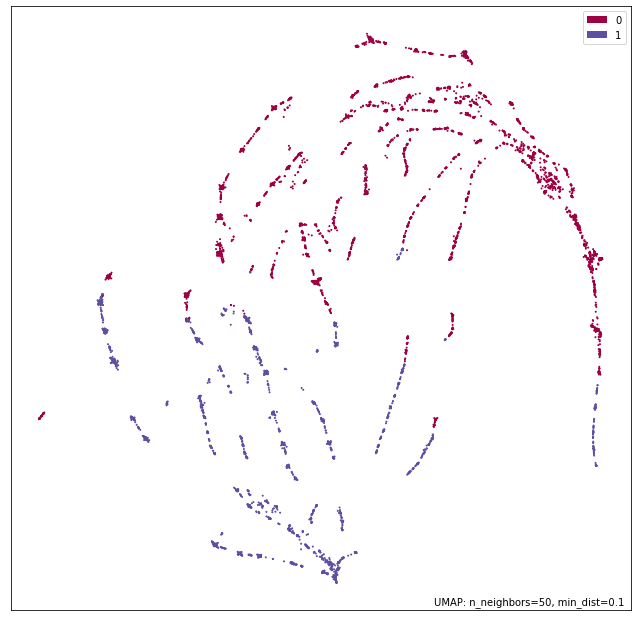

In [85]:
mapper = gs.best_estimator_['dim_reduction'].fit(X)
umap.plot.points(mapper, labels=gs.best_estimator_['cluster'].labels_)

## Extra.4 Lets try with a simple KMeans so we can define a higher number of clusters

### The issue with MeanShift is that the number of cluster is usually low, lets try KMeans which have the number of clusters as a parameter

In [86]:
umap_model = umap.UMAP(n_neighbors=5)
kmean = MiniBatchKMeans()

pipe = Pipeline(steps=[("scaling", standard_scaler), ('dim_reduction', umap_model), ("cluster", kmean)])

param_grid = {'scaling': ['passthrough'],
              'dim_reduction__n_neighbors': [100, 150, 200, 250, 300],
              'cluster__n_clusters': [10, 20, 30],
              'cluster__batch_size': [256*12]
              }

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=clustereing_score, cv=cv, error_score='raise', refit='calinski_harabasz')

start_time = time.time()
gs.fit(X);
computation_time = time.time() - start_time


In [87]:
gs.best_estimator_

Pipeline(steps=[('scaling', 'passthrough'),
                ('dim_reduction',
                 UMAP(n_neighbors=200, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('cluster', MiniBatchKMeans(batch_size=3072, n_clusters=10))])

<AxesSubplot:>

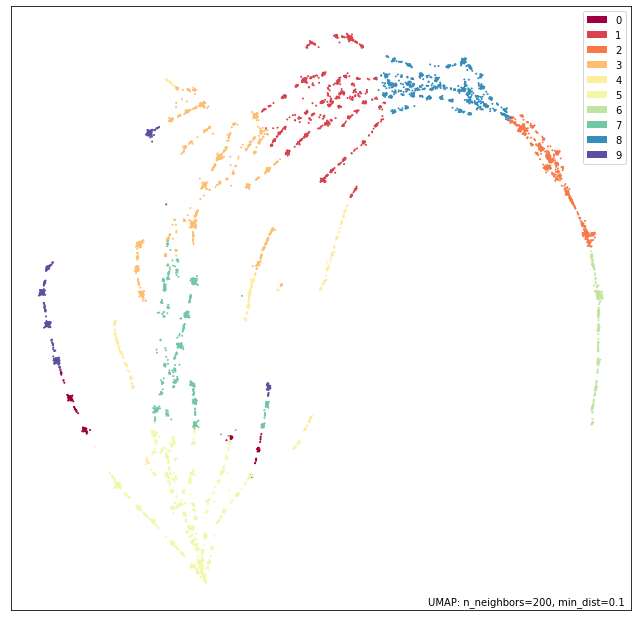

In [88]:
mapper = gs.best_estimator_['dim_reduction'].fit(X)
umap.plot.points(mapper, labels=gs.best_estimator_['cluster'].labels_)

### This seems promising, and would probably be a good path to follow in the future